In [234]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [235]:
from rlway.pyosrd.osrd import OSRD

In [236]:
sim = OSRD(use_case='cvg_dvg', dir='tmp')

[19:28:59,195] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[19:28:59,244] [INFO]              [FullInfra] parsing infra
[19:28:59,306] [INFO]              [FullInfra] adaptation to kotlin
[19:28:59,338] [INFO]              [FullInfra] loading signals
[19:28:59,343] [INFO]              [FullInfra] building blocks
[19:28:59,348] [INFO]  [StandaloneSimulationCommand] Loading input: tmp/simulation.json
[19:28:59,360] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.42
[19:28:59,406] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.43
[19:28:59,412] [INFO]  [StandaloneSimulationCommand] All simulations completed
[19:28:59,412] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp/results.json


In [237]:
sim.points_encountered_by_train(0)

[{'id': 'departure_train0', 'offset': 0.0, 'type': 'departure', 't_base': 0.0},
 {'id': 'station0', 'offset': 0.0, 'type': 'station', 't_base': 0.0},
 {'id': 'S0', 'offset': 130.0, 'type': 'signal', 't_base': 23.60222834989134},
 {'id': 'D0',
  'offset': 150.0,
  'type': 'detector',
  't_base': 25.29004646237633},
 {'id': 'CVG', 'offset': 200.0, 'type': 'switch', 't_base': 29.50959174358881},
 {'id': 'D2',
  'offset': 250.0,
  'type': 'detector',
  't_base': 32.871583384452784},
 {'id': 'S2', 'offset': 270.0, 'type': 'signal', 't_base': 34.17127025987636},
 {'id': 'S3', 'offset': 1130.0, 'type': 'signal', 't_base': 72.80078606581122},
 {'id': 'D3',
  'offset': 1150.0,
  'type': 'detector',
  't_base': 73.61711259642347},
 {'id': 'DVG',
  'offset': 1200.0,
  'type': 'switch',
  't_base': 75.88004567663229},
 {'id': 'D4',
  'offset': 1250.0,
  'type': 'detector',
  't_base': 78.20562707198113},
 {'id': 'S4', 'offset': 1270.0, 'type': 'signal', 't_base': 79.13585963012066},
 {'id': 'stati

In [238]:
from copy import copy
import json
import os

disturbed = copy(sim)
disturbed.simulation_json='disturbed/simulation.json'
disturbed.results_json='disturbed/results.json'
!mkdir -p tmp/disturbed
disturbed.simulation['train_schedule_groups'][0]['schedules'][0]['stops']+=[{'duration': 90, 'position': 130}]
with open(os.path.join(disturbed.dir, disturbed.simulation_json), "w") as outfile:
    json.dump(disturbed.simulation, outfile)
disturbed.run()


regulated = copy(disturbed)
regulated.simulation_json='disturbed/regulated/simulation.json'
regulated.results_json='disturbed/regulated/results.json'
!mkdir -p tmp/disturbed/regulated
regulated.simulation['train_schedule_groups'][1]['schedules'][0]['stops']+=[{'duration': 90, 'position': 130}]
with open(os.path.join(regulated.dir, regulated.simulation_json), "w") as outfile:
    json.dump(regulated.simulation, outfile)
regulated.run()

[19:28:59,926] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[19:28:59,957] [INFO]              [FullInfra] parsing infra
[19:29:00,024] [INFO]              [FullInfra] adaptation to kotlin
[19:29:00,055] [INFO]              [FullInfra] loading signals
[19:29:00,061] [INFO]              [FullInfra] building blocks
[19:29:00,066] [INFO]  [StandaloneSimulationCommand] Loading input: tmp/disturbed/simulation.json
[19:29:00,078] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.42
[19:29:00,123] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.43
[19:29:00,128] [INFO]  [StandaloneSimulationCommand] All simulations completed
[19:29:00,128] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp/disturbed/results.json
[19:29:00,579] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[19:29:00,612] [INFO]              [FullInfra] parsing infra
[19:29:00,674] [INFO]              [Full

<Axes: title={'center': 'train1 (base)'}, xlabel='Time [min]'>

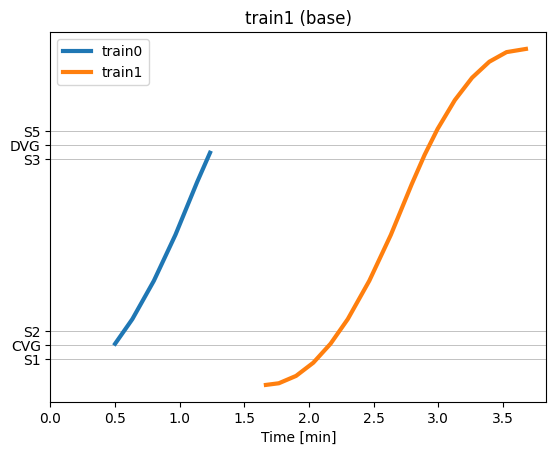

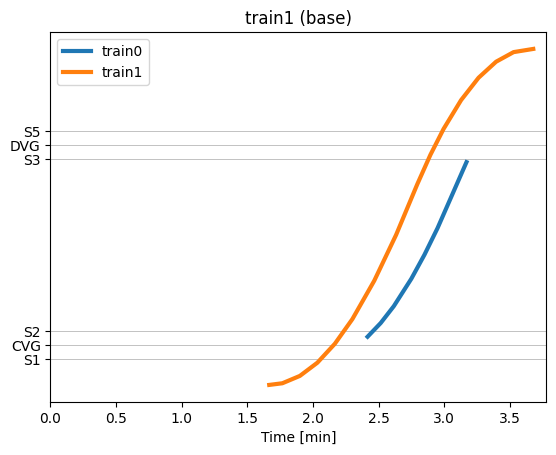

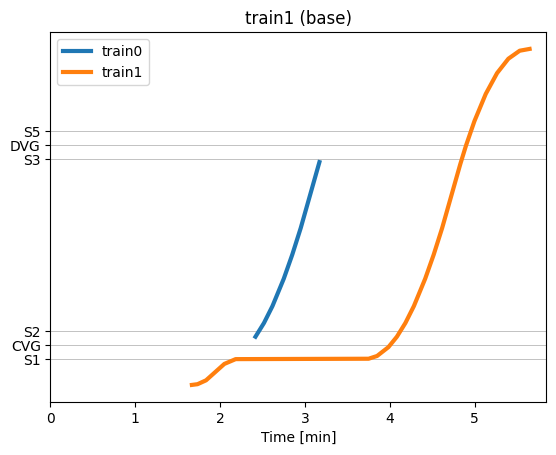

In [241]:
import matplotlib.pyplot as plt
points_to_show=['switch', 'signal']
sim.space_time_graph(1,  points_to_show=points_to_show)
disturbed.space_time_graph(1,  points_to_show=points_to_show)
regulated.space_time_graph(1,  points_to_show=points_to_show)